<a href="https://colab.research.google.com/github/JeongJiHeon/ScoreDiffusionModel/blob/main/NCSN_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Define
### First, we defined the sigmas of perturbation distibutsions.
$$ q_{\sigma}(x)=\int p_{data}(t)\mathcal(x \vert t, \sigma^2\mathbf{I}), \ \ \ \ \ \ \frac{\sigma_{1}}{\sigma_{2}}=\frac{\sigma_{2}}{\sigma_{3}}=\cdots=\frac{\sigma_{L-1}}{\sigma_{L}} > 1$$
### and
$$ q_{\sigma}(\tilde{x} \vert x)=\mathcal{N}(\tilde{x} \vert x, \sigma^2\mathbf{I}). \ \ \text{In other word},\ \ \ \tilde{x}=x+\sigma*z,\ \ where\ \ z\sim\mathcal{N}(0, \mathbf{I})$$

### And, we defined a score model dependent on time.
$$ \mathbf{s}_{\theta}(x_t, \sigma) \approx \nabla_x \log{q_\sigma}(x)$$

### If perturbation distributsions were defined by sigmas, then the score of perturbation distribution is:
$$ \nabla_{\tilde{x}}\log q_{\sigma}(\tilde{x}\vert{x})=-\frac{(\tilde{x}-x)}{\sigma^2}=-\frac{z}{\sigma} $$


### Then, we can used a objective function for Langevin dynamics.

$$ \mathcal{L}(\theta, \{ \sigma_{i}\}_{i=1}^L)=\frac{1}{L}\sum_{i=1}^L\lambda({\sigma_i})\mathcal{l}(\theta;\sigma_i),\ \ \ 
where\ \ \ \mathcal{l}(\theta;\sigma_i)=\frac{1}{2}\mathbb{E}_{p_{data}(x)}\mathbb{E}_{\tilde{x}\sim\mathcal{N}(x,\sigma^2\mathbf{I})}[\Vert \mathbf{s}_{\theta}(\tilde{x}, \sigma)+\frac{\tilde{x}-x}{\sigma^2}\Vert^2_2]
$$


In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output

class Model(nn.Module):
    def __init__(self, device, L, sigma_min, sigma_max, p=0.5):
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L)).to(device = device)
        
        self.linear_model1 = nn.Sequential(
            nn.Linear(2, 256),
            nn.Dropout(p),
            nn.GELU(),
            

        )
        self.Embedding = nn.Embedding(L, 256)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 2),
        )
        
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)

        
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x)
        embed = self.Embedding(idx)
        output = self.linear_model2(output + embed)

        return (output, target, used_sigmas) if get_target else output

# When sampling, we used Langevin dynamic

$$\tilde{x}_{t} = \tilde{x}_{t-1}+\frac{\epsilon}{2}\nabla_{x}{\log}p(\tilde{x}_{t-1})+\sqrt{\epsilon}z_{t}$$

In [2]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.T = T
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        for _ in range(self.T):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_diffusion_step(self, x):
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        sample = (torch.rand([sampling_number,2]).to(device = self.device) - 0.5)*2
        sampling_list = []
        
        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)



In [3]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [4]:
def scatter(sample, only_final, scatter_range = [-10, 10]):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y = scatter[:,0], scatter[:,1]
        plt.figure(figsize=(7, 7))

        plt.xlim(scatter_range)
        plt.ylim(scatter_range)
        plt.rc('axes', unicode_minus=False)

        plt.scatter(scatter_x, scatter_y, s=5)
        plt.show()
    
    else:
        step_size = sample.size(0)
        fig, axs = plt.subplots(1, step_size, figsize=(step_size * 4, 4), constrained_layout = True)
        for i in range(step_size):
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y = scatter[:,0], scatter[:,1]
            axs[i].scatter(scatter_x, scatter_y, s=5)
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
        plt.show()

# Example 1

$$0.2 \times \mathcal{N}((3,3), I) + 0.8 \times \mathcal{N}((-3,-3), I)$$

In [5]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2, shape = (2), probability=0.2, total_len = 1000000):
        self.dist1_mean, self.dist1_var = dist1[0], dist1[1]
        self.dist2_mean, self.dist2_var = dist2[0], dist2[1]
        self.shape = shape
        self.probability = probability
        self.total_len = total_len
        
    @property
    def get_probability(self):
        return torch.rand(1) < self.probability
        
    @property
    def _sampling_1(self):
        return self.dist1_mean + torch.randn(self.shape) * self.dist1_var

    @property
    def _sampling_2(self):
        return self.dist2_mean + torch.randn(self.shape) * self.dist2_var

    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        data = self._sampling_1 if self.get_probability else self._sampling_2

        return data

In [19]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 10

L = 10
T = 100

total_iteration = 1000
current_iteration = 0
display_iteration = 200
scatter_range = [-10, 10]

batch_size = 8192 * 2

dist1 = (3, 1)
dist2 = (-3, 1)
dataloader = torch.utils.data.DataLoader(DataSet(dist1, dist2, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)


sampling_number = 1000
device = torch.device('cuda')
only_final = True

dataiterator = iter(dataloader)

model = Model(device, L, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)

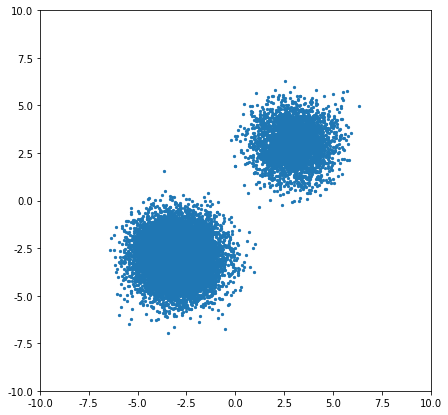

In [20]:
scatter(next(iter(dataloader)), True)

In [21]:
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

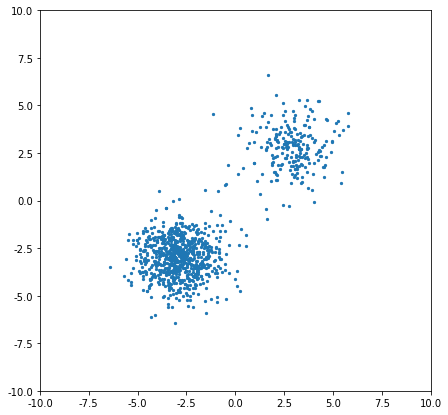

In [22]:
while current_iteration != total_iteration:
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        scatter(sample, only_final, scatter_range = scatter_range)
        losses.reset()


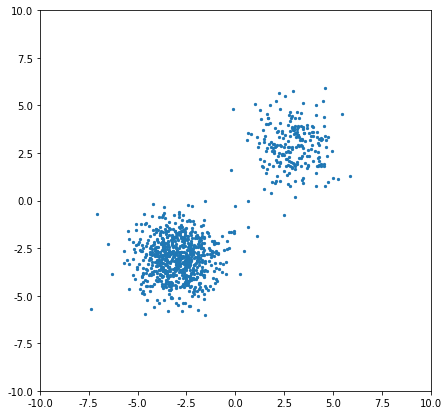

In [23]:
sampling_number = 1000
only_final = True
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range= scatter_range)

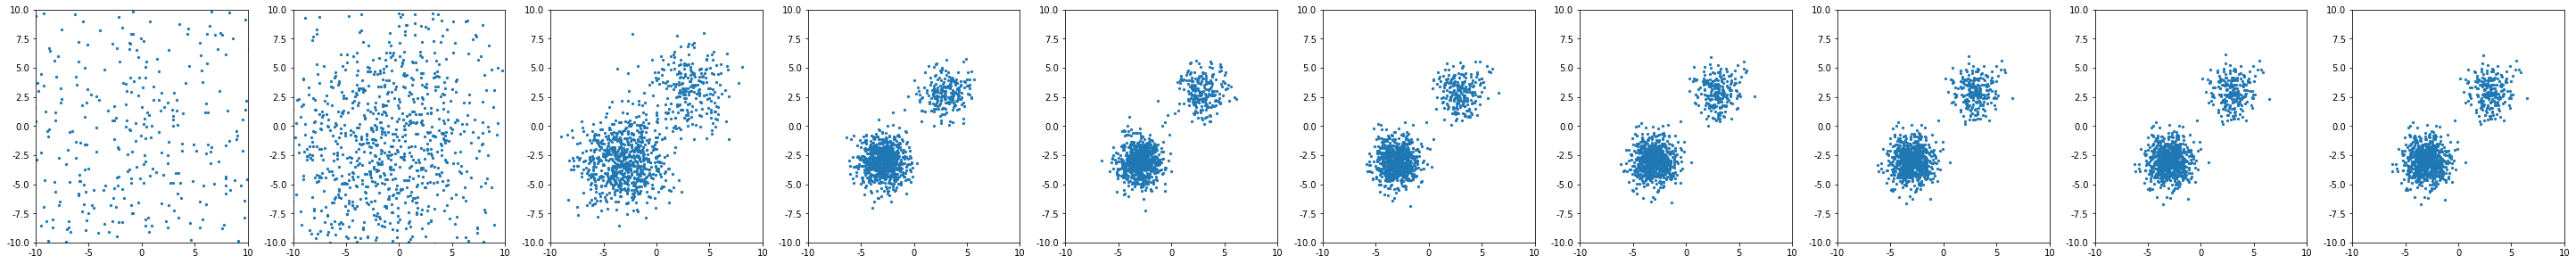

In [27]:
eps = 2e-6
sampling_number = 1000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

In [28]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
# ani.save('ncsn_toy.gif')
HTML(ani.to_jshtml())

# Example 2

In [30]:
class DataSet2(torch.utils.data.Dataset):
    def __init__(self, dist, shape = (2), total_len = 1000000):
        self.dist_mean, self.dist_var, self.dist_num = dist[0], dist[1], dist[2]
        self.distribution_list = np.stack([ np.dot([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]], dist[0]) for angle in np.linspace(start=0, stop=2 * np.pi, num = dist[2]+1)])
        self.shape = shape
        self.total_len = total_len
        
    @property
    def _choose_distribution(self):
        return int(torch.rand(1) * self.dist_num)
        
    @property
    def _sampling(self):
        dist_idx = self._choose_distribution
        return torch.from_numpy(self.distribution_list[dist_idx]).float() + torch.randn(self.shape) * self.dist_var


    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        data = self._sampling

        return data

In [33]:
eps = 1e-5
sigma_min = 0.005
sigma_max = 10

L = 10
T = 100

total_iteration = 3000
current_iteration = 0
display_iteration = 200
scatter_range = [-20, 20]

batch_size = 8192 * 2

dist = [[10,0], 1, 8]
dataloader = torch.utils.data.DataLoader(DataSet2(dist, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)


sampling_number = 1000
device = torch.device('cuda')
only_final = True

dataiterator = iter(dataloader)

model = Model(device, L, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr = 0.002)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)

In [34]:
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

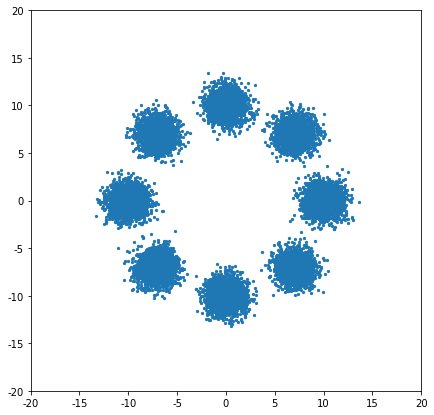

In [36]:
scatter(next(iter(dataloader)), True, scatter_range)

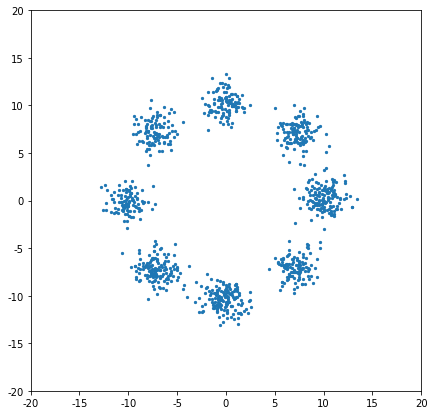

In [37]:
while current_iteration != total_iteration:
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        scatter(sample, only_final, scatter_range = scatter_range)


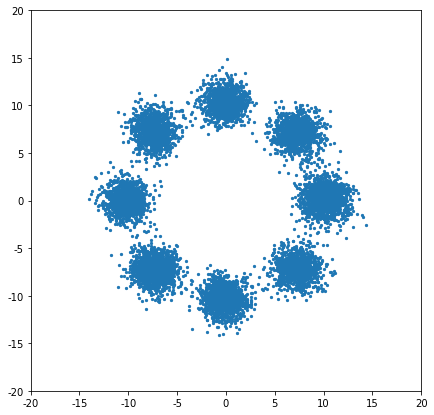

In [38]:
sampling_number = 10000
only_final = True
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range= scatter_range)

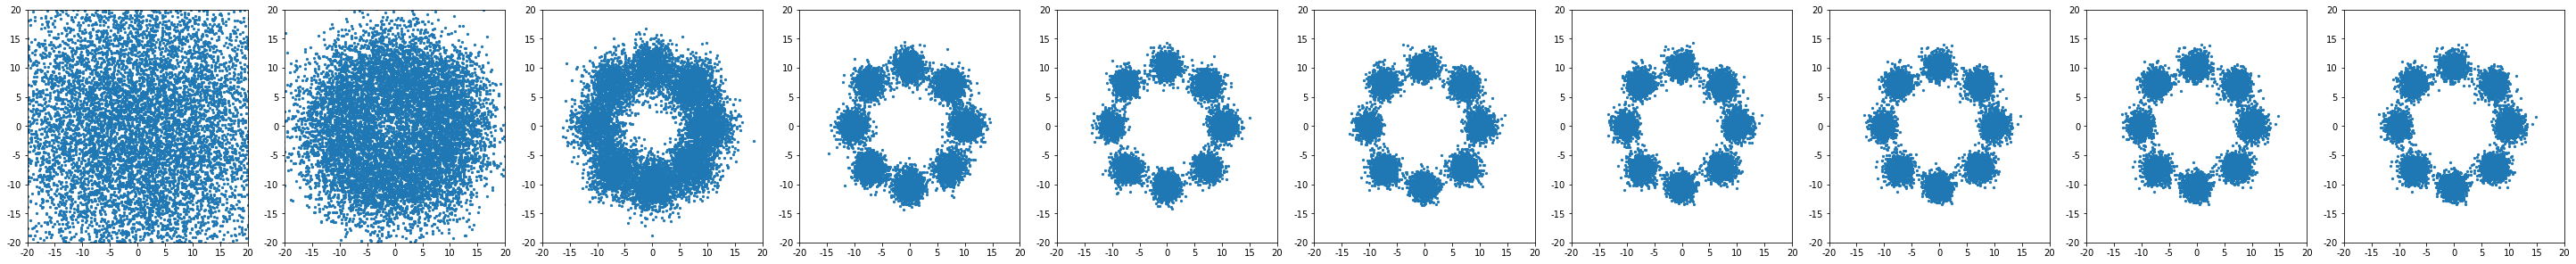

In [39]:
sampling_number = 10000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, L, T, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

In [40]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
# ani.save('ncsn_toy2.gif')
HTML(ani.to_jshtml())

MovieWriter stderr:
[gif @ 0x55bb3afac600] GIF muxer supports only a single video GIF stream.
Could not write header for output file #0 (incorrect codec parameters ?): Invalid argument
Error initializing output stream 0:0 -- 



CalledProcessError: ignored

In [ ]:
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
# ani.save('ncsn_toy2.gif')
HTML(ani.to_jshtml())